In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from pathlib import Path

import matplotlib.pyplot as plt
import motorlab as ml
import numpy as np
import seaborn as sns
import torch
import yaml

In [3]:
os.chdir(Path().resolve().parent)

in this notebook i want to analyse which principal components are the most important for predicting location out of poses.

i already trained a model in which i project poses into pcs and then use the projection to predict location. here i just want to check which pcs are the most relevant. i plan to do this as follows: plot the gradient of the tiles in the y-axis with respect to each pc and also zero out the pcs and check if both analysis agree with each other.

In [4]:
run = 20250715175243  # no pcs removed, only projected to.

In [5]:
config_path = f"config/poses_to_position/{run}.yaml"
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

In [6]:
model = ml.model.create_model(
    config,
    is_train=False,
)

In [7]:
test_intervals, train_intervals, _ = ml.utils.get_tiers_intervals(
    config["DATA_DIR"],
    config["sessions"],
    config["experiment"],
    config["intervals"]["include_trial"],
    config["intervals"]["include_homing"],
    config["intervals"]["include_sitting"],
)

In [8]:
data_dict = ml.data.load_all(config, train_intervals)

In [9]:
pcs = {session: [] for session in config["sessions"]}

for session, data in data_dict.items():
    X = data["poses"]
    y = data["position"]
    for pc in range(X.shape[-1]):
        pc_mse = []
        tmp = X[:, pc].copy()
        for _ in range(10):
            X[:, pc] = np.random.permutation(X[:, pc])
            mse_intervals = []
            for s, e in test_intervals[session]:
                pred = model(
                    torch.tensor(X[s:e], device=ml.utils.device), session
                )
                pred = pred.detach().cpu().numpy()
                mse_intervals.append(np.mean((pred - y[s:e]) ** 2))
            pc_mse.append(np.mean(mse_intervals).item())
        X[:, pc] = tmp
        pcs[session].append(np.mean(pc_mse).item())

In [10]:
baseline = dict()

for session, data in data_dict.items():
    X = data["poses"]
    y = data["position"]
    mse_intervals = []
    for s, e in test_intervals[session]:
        pred = model(torch.tensor(X[s:e], device=ml.utils.device), session)
        pred = pred.detach().cpu().numpy()
        mse_intervals.append(np.mean((pred - y[s:e]) ** 2))
    baseline[session] = np.mean(mse_intervals).item()

In [12]:
results_dict = {
    "session": [],
    "mse": [],
    "pc": [],
}

for session, mses in pcs.items():
    # mses = np.delete(mses, pcs_to_exclude[session])
    results_dict["session"].extend([session] * len(mses))
    results_dict["mse"].extend(mses)
    results_dict["pc"].extend(list(range(len(mses))))

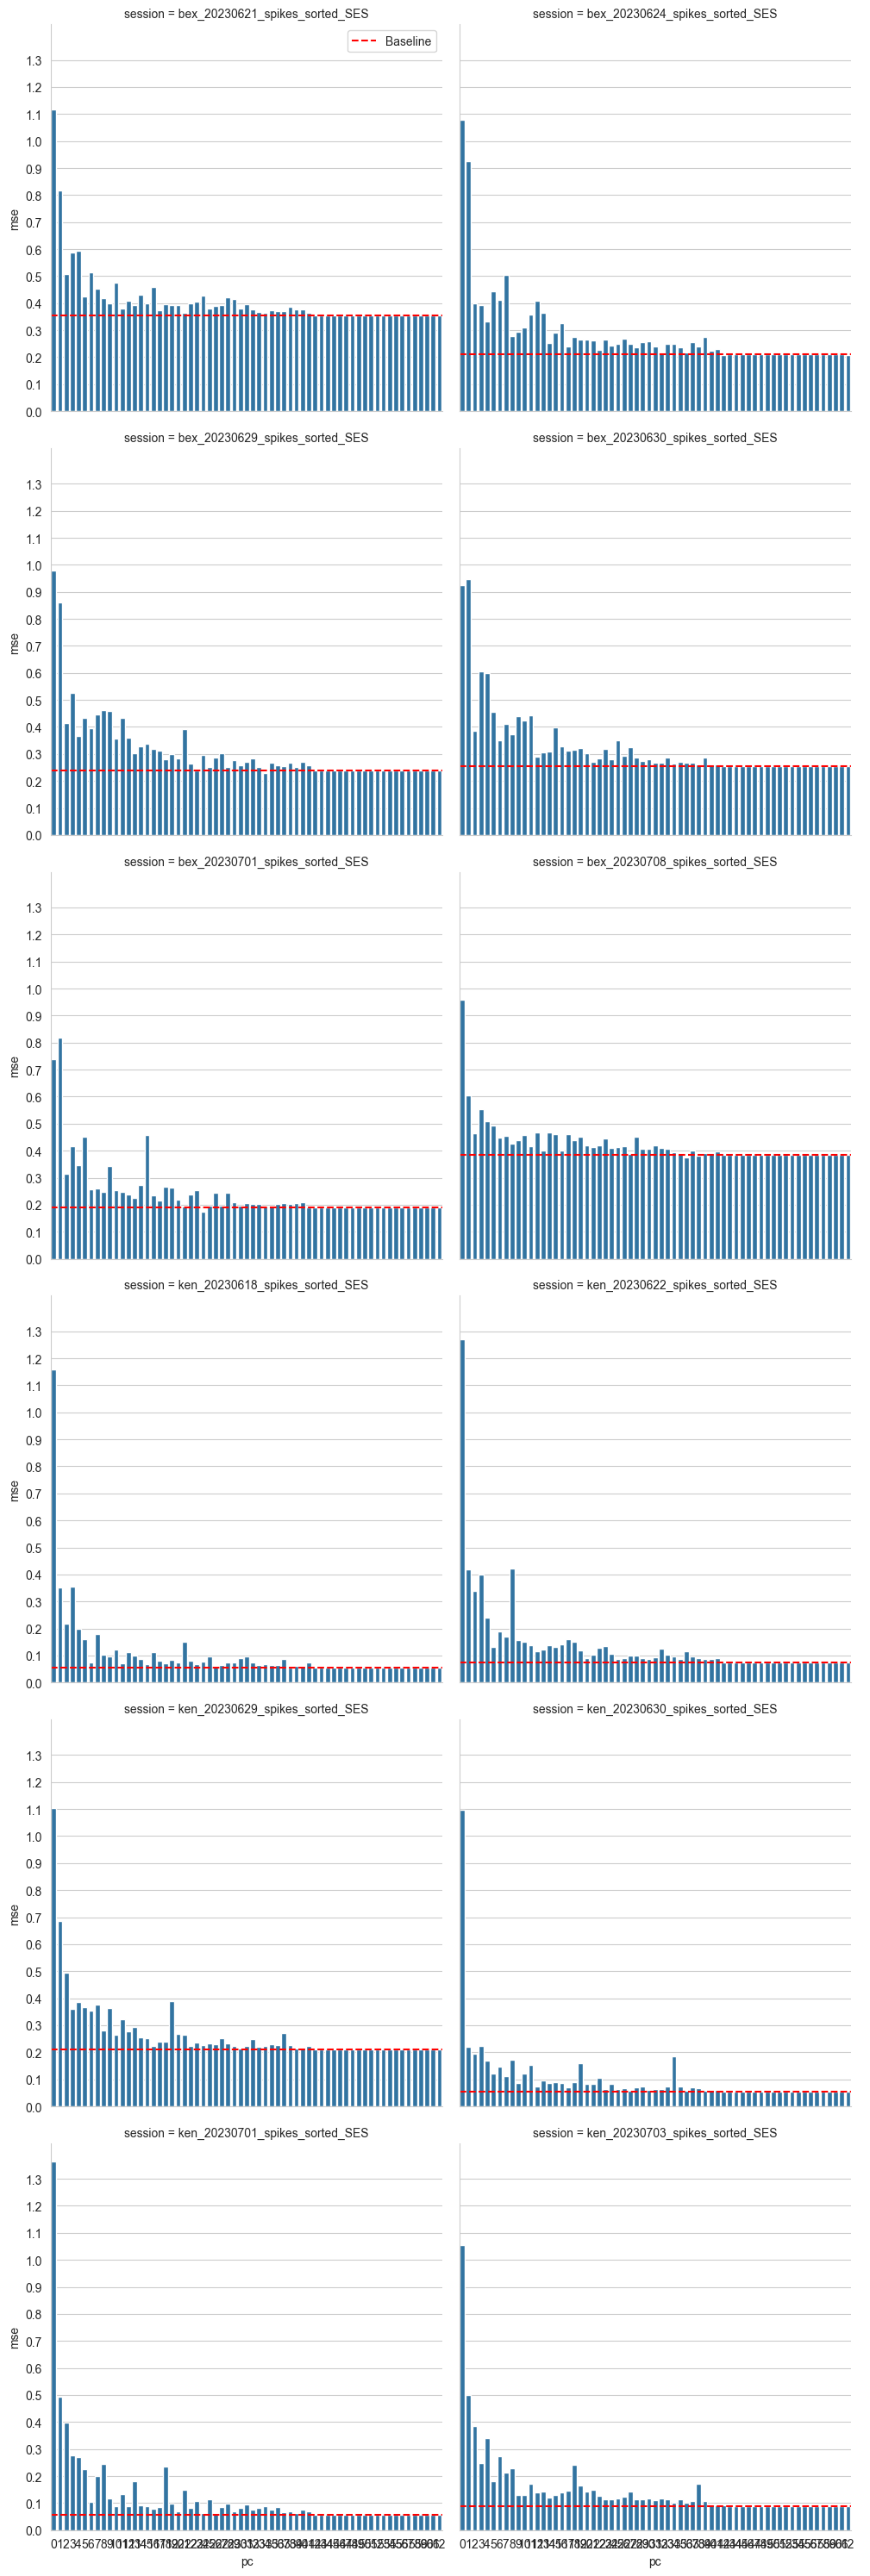

In [13]:
sns.set_style("whitegrid")

g = sns.catplot(
    data=results_dict, x="pc", y="mse", col="session", col_wrap=2, kind="bar"
)

for ax in g.axes.flatten():
    # Extract session name from title
    title = ax.get_title()  # e.g., 'session = bex_20230621_spikes_sorted_SES'
    session = title.split(" = ")[-1]

    # Plot the horizontal line at the baseline value
    ax.axhline(
        y=baseline[session], color="red", linestyle="--", label="Baseline"
    )

# Optional: add legend (once)
g.axes.flatten()[0].legend(loc="upper right")
g.set(yticks=np.arange(0, 1.4, 0.1))
plt.tight_layout()
plt.show()

In [ ]:
pcs_to_exclude = dict()

for session, mses in pcs.items():
    mses = np.array(mses)
    pcs_to_exclude[session] = np.where(mses >= 0.01 + baseline[session])[
        0
    ].tolist()

In [ ]:
_, pcas = ml.utils.project_to_pca(
    data_dict[session]["poses"], train_intervals[session]
)

ValueError: too many values to unpack (expected 2)

In [ ]:
pcs_to_exclude

{'bex_20230621_spikes_sorted_SES': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40],
 'bex_20230624_spikes_sorted_SES': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  33,
  34,
  35,
  37,
  38,
  39,
  40,
  41],
 'bex_20230629_spikes_sorted_SES': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  35,
  36,
  37,
  38,
  39,
  40,
  41],
 'bex_20230630_spikes_sorted_SES': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
 